<div class='alert alert-block alert-info'>Ophalen belasting-waarden vanuit een Waterinfo service</div>

In [1]:
# importeer de benodigde bibliotheken
import os
from pathlib import Path

# voor het plotten van de data
import matplotlib.pyplot as plt
import numpy as np

# Vanuit toolbox gebruiken we standaard 'Config' en 'DataAdapter'.
# De functie die we willen gebruiken om data op te halen is 'LoadsWaterinfo'
from toolbox_continu_inzicht.base.config import Config
from toolbox_continu_inzicht.base.data_adapter import DataAdapter
from toolbox_continu_inzicht.loads import LoadsWaterinfo
from toolbox_continu_inzicht import datetime_from_epoch

# Hiermee kan je markdown printen tijdens uitvoeren van functie
from IPython.display import display, Markdown

**loads_waterinfo_config.yaml:**
```Yaml
GlobalVariables:
    rootdir: "data_sets"   

    csv:
        delimiter: ","

    LoadsWaterinfo:
        datatype: "waterhoogte"
        observedhours: 48
        predictionhours: 48
        momentsupdate: True
        MISSING_VALUE: -9999.0
        moments: [-24,0,24,48]

DataAdapter: 
    locaties: 
        type: csv
        path: "locations_waterinfo.csv"
    waterstanden: 
        type: csv
        path: "waterstanden.csv"
```

**locations_waterinfo.csv:**
```csv
id,name,code
1,Rottedamse hoek,Rotterdamse-hoek(FL02)-1
2,Dordrecht,Dordrecht(DORD)
3,Moerdijk,Moerdijk(MOER)
4,Pannerdense kop,Pannerdense-kop(PANN)
5,IJsselkop,IJsselkop(IJSS)
6,Den helder,Den-Helder(DENH)
```

In [2]:
# Path naar config bestand
config_file = Path("data_sets/loads_waterinfo_config.yaml")
if os.path.exists(config_file):
    # Maak config aan, deze gebruiken we om de adapter aan te maken
    display(
        Markdown("*Maak config aan, deze gebruiken we om de adapter aan te maken.*")
    )
    config = Config(config_path=config_file)
    config.lees_config()

    display(Markdown("*Maak DataAdapter aan, deze gebruiken bij de functie.*"))
    data_adapter = DataAdapter(config=config)
else:
    display(Markdown(f"**⚠️ Config file '{config_file}' not found.**"))

*Maak config aan, deze gebruiken we om de adapter aan te maken.*

*Maak DataAdapter aan, deze gebruiken bij de functie.*

In [3]:
# Oude gegevens verwijderen
display(Markdown("Oude gegevens verwijderen"))

output_info = config.data_adapters
output_file = Path(
    config.global_variables["rootdir"] / Path(output_info["waterstanden"]["path"])
)
if os.path.exists(output_file):
    os.remove(output_file)

Oude gegevens verwijderen

In [6]:
# Gebruik de 'LoadsWaterinfo' om gegevens uit Waterinfo te halen
display(Markdown("Gebruik de 'LoadsWaterinfo' om gegevens uit Waterinfo te halen"))
waterinfo = LoadsWaterinfo(
    data_adapter=data_adapter, input="locaties", output="waterstanden"
)

# Omdat de data via een asynchrone functie opgehaald
# wordt is de run ook asynchroon gemaakt
display(Markdown("Voer de functie uit."))
df_out = await waterinfo.run()

Gebruik de 'LoadsWaterinfo' om gegevens uit Waterinfo te halen

Voer de functie uit.

In [7]:
# test of we data hebben opgehaald
if os.path.exists(output_file):
    display(Markdown(f"*{output_file} is aangemaakt.*"))
else:
    display(Markdown(f"*{output_file} is niet aangemaakt.*"))

# controleer de opgehaalde waarden
display(Markdown("**Controleer de opgehaalde waarden**"))
print(waterinfo.df_out)

*data_sets\waterstanden_waterinfo.csv is aangemaakt.*

**Controleer de opgehaalde waarden**

      objectid        objecttype  parameterid      datetime  value  \
0            1  measuringstation            1  1.729501e+12  -0.29   
1            1  measuringstation            1  1.729502e+12  -0.29   
2            1  measuringstation            1  1.729502e+12  -0.29   
3            1  measuringstation            1  1.729503e+12  -0.30   
4            1  measuringstation            1  1.729504e+12  -0.29   
...        ...               ...          ...           ...    ...   
4061         6  measuringstation           99  1.729843e+12  -0.06   
4062         6  measuringstation           99  1.729844e+12  -0.02   
4063         6  measuringstation           99  1.729844e+12   0.02   
4064         6  measuringstation           99  1.729845e+12   0.06   
4065         6  measuringstation           99  1.729846e+12   0.10   

      calculating  
0            True  
1            True  
2            True  
3            True  
4            True  
...           ...  
4061         True  

In [14]:
# split de dataframe in tweeën & process
values_nan = df_out[df_out["value"] == 999999999.0].index
for val in values_nan:
    df_out.loc[val, "value"] = np.nan
df_out.sort_index()

df_plot = df_out.set_index(df_out["datetime"].apply(lambda x: datetime_from_epoch(x)))
df_plot = df_plot[df_plot["objectid"] == 2]

measurement_index = df_plot["parameterid"] == 1
forecast_index = df_plot["parameterid"] == 99
df_plot_measurements = df_plot[measurement_index][["value"]]
df_plot_forecast = df_plot[forecast_index][["value"]]

In [16]:
df_plot_measurements

,value
datetime,
2024-10-21 09:00:00+00:00,0.33
2024-10-21 09:10:00+00:00,0.32
2024-10-21 09:20:00+00:00,0.31
2024-10-21 09:30:00+00:00,0.29
2024-10-21 09:40:00+00:00,0.28
...,...
2024-10-23 07:50:00+00:00,1.00
2024-10-23 08:00:00+00:00,0.99
2024-10-23 08:10:00+00:00,0.97


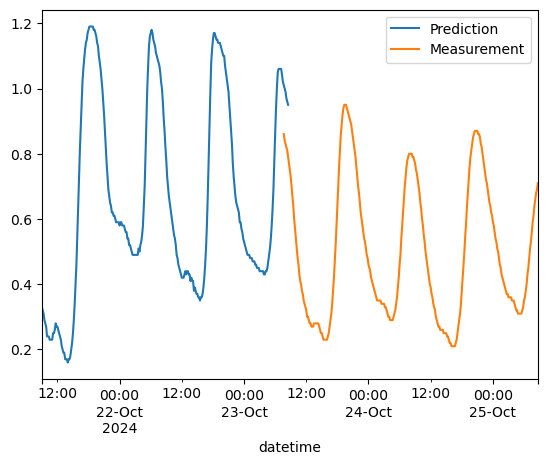

In [17]:
fig, ax = plt.subplots()
df_plot_measurements.plot(color="C0", ax=ax)
df_plot_forecast.plot(color="C1", ax=ax)
ax.legend(["Prediction", "Measurement"])